<a href="https://colab.research.google.com/github/Liza-b-13/liza-repo/blob/main/notebook/detection_PE_Headers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Détection de malwares par machine automatique utilisant les PE Headers**

(Pour les premiers tests j'utiliserais un jeu de données différent que celui prévu...)


### **Jeu de données**
- Fichiers légitimes : 41 323 binaires Windows  
- Fichiers malveillants : 96 724 téléchargés depuis VirusShare  
- Total : 138 048 fichiers  
- Créé par : Prateek Lalwani  
- Lien du dataset :  [link](https://github.com/PacktPublishing/Mastering-Machine-Learning-for-Penetration-Testing/blob/master/Chapter03/MalwareData.csv.gz)

### **Qu’est-ce que les PE headers ?**
Les **PE headers** (Portable Executable headers) sont des structures au début d’un fichier exécutable Windows (.exe, .dll, .sys…).  
Ils contiennent des informations essentielles comme :  
- Type et architecture du fichier (32-bit ou 64-bit)  
- Sections du fichier (code, données, ressources…)  
- Adresses et tailles des sections en mémoire  
- Bibliothèques et fonctions importées/exportées  

En analyse de malware, les PE headers permettent de **différencier un fichier légitime d’un fichier malveillant** grâce à certaines de leurs caractéristiques.



---


### **Prétraitement du jeu de données:**

In [18]:
# ==============================
# 1. Imports
# ==============================
import pandas as pd

In [19]:
# ==============================
# 2. Chargement du dataset
# ==============================
url = "https://raw.githubusercontent.com/PacktPublishing/Mastering-Machine-Learning-for-Penetration-Testing/master/Chapter03/MalwareData.csv.gz"

# Lecture directe depuis le fichier gzip
print("Chargement du dataset...")
MalwareDataset = pd.read_csv(url, compression='gzip', sep='|', low_memory=False)

# Forme du dataset et petit preview
print("Shape du dataset: %s" % (MalwareDataset.shape,))
MalwareDataset.head(3) #trois première lignes

Chargement du dataset...
Shape du dataset: (138047, 57)


,Name,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,memtest.exe,631ea355665f28d4707448e442fbf5b8,332,224,258,9,0,361984,115712,0,...,4,3.262823,2.568844,3.537939,8797.000000,216,18032,0,16,1
1,ose.exe,9d10f99a6712e28f8acd5641e3a7ea6b,332,224,3330,9,0,130560,19968,0,...,2,4.250461,3.420744,5.080177,837.000000,518,1156,72,18,1
2,setup.exe,4d92f518527353c0db88a70fddcfd390,332,224,3330,9,0,517120,621568,0,...,11,4.426324,2.846449,5.271813,31102.272727,104,270376,72,18,1


In [20]:
Legit = MalwareDataset[0:41323].drop(['legitimate'], axis=1)
Malware = MalwareDataset[41323::].drop(['legitimate'], axis=1)

print("The shape of the legit dataset is: %s samples, %s features"%(Legit.shape[0], Legit.shape[1]))
print("The shape of the malware dataset is: %s samples, %s features"%(Malware.shape[0],Malware.shape[1]))

The shape of the legit dataset is: 41323 samples, 56 features
The shape of the malware dataset is: 96724 samples, 56 features


In [21]:
#print de toutes les features du dataset
print(MalwareDataset.columns)

Index(['Name', 'md5', 'Machine', 'SizeOfOptionalHeader', 'Characteristics',
       'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode',
       'SizeOfInitializedData', 'SizeOfUninitializedData',
       'AddressOfEntryPoint', 'BaseOfCode', 'BaseOfData', 'ImageBase',
       'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion',
       'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorImageVersion',
       'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfImage',
       'SizeOfHeaders', 'CheckSum', 'Subsystem', 'DllCharacteristics',
       'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve',
       'SizeOfHeapCommit', 'LoaderFlags', 'NumberOfRvaAndSizes', 'SectionsNb',
       'SectionsMeanEntropy', 'SectionsMinEntropy', 'SectionsMaxEntropy',
       'SectionsMeanRawsize', 'SectionsMinRawsize', 'SectionMaxRawsize',
       'SectionsMeanVirtualsize', 'SectionsMinVirtualsize',
       'SectionMaxVirtualsize', 'ImportsNbDLL', 'ImportsNb',
       'Impor

In [22]:
import sklearn
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

In [23]:
# Vérification les valeurs manquantes
print("Valeurs manquantes :", MalwareDataset.isnull().sum().sum())

# Séparation des features et de la variable cible
X = MalwareDataset.drop(['Name','md5','legitimate'], axis=1).values # .values converti le tableau panda en un tableau numpy plus mathématique
Y = MalwareDataset['legitimate'].values

# Vérification du type de données
print("Type des features :", X.dtype)
print("Taille du dataset :", X.shape)


Valeurs manquantes : 0
Type des features : float64
Taille du dataset : (138047, 54)




---


### 🌿 **Decision Tree Classifier**
Nous formons un modèle Extra Trees pour déterminer l’importance des fonctionnalités, puis utilisons ces informations pour créer un nouvel ensemble de données (`X_new`) contenant uniquement les fonctionnalités les plus pertinentes pour notre tâche de détection de logiciels malveillants.

In [24]:
# ==================================================
# 2. Selection des features importantes uniquement
# ==================================================

# Entraînement d'un modèle Extra Trees pour estimer l'importance des features
extratrees = ExtraTreesClassifier().fit(X, Y)

# Sélection automatique des features les plus importantes
# (on fixe ici un seuil clair pour la reproductibilité)
select = SelectFromModel(extratrees, prefit=True, threshold="median")
X_new = select.transform(X)

print("shape of the old dataset %s , shape of the new dataset %s"  %(X.shape, X_new.shape))
print(f"Réduction de dimensions : {X.shape[1]} → {X_new.shape[1]} features")

shape of the old dataset (138047, 54) , shape of the new dataset (138047, 27)
Réduction de dimensions : 54 → 27 features


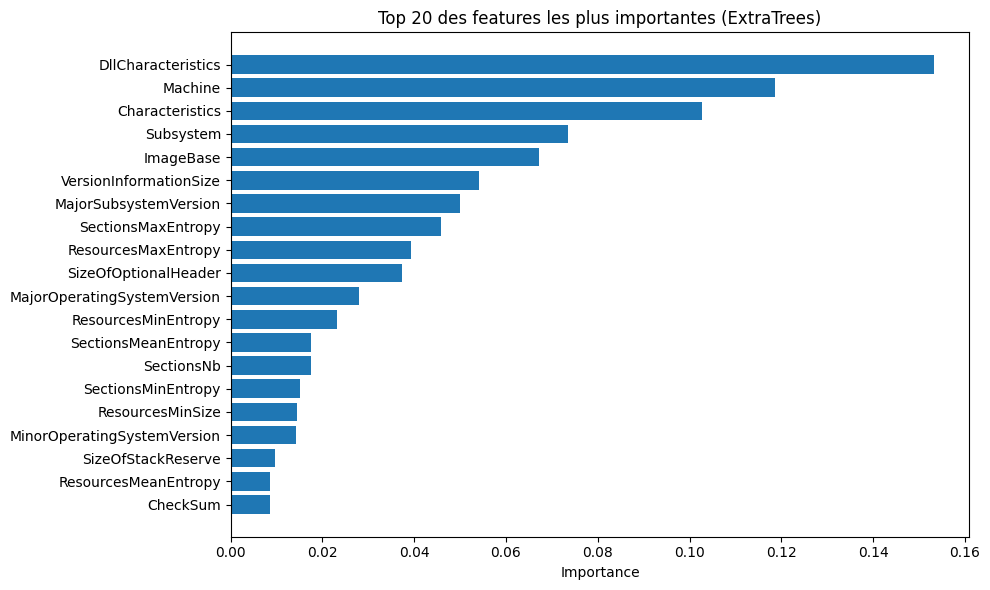

In [25]:
import matplotlib.pyplot as plt

# --- Classement des features selon leur importance ---
features = X_new.shape[1]  # number of selected features
importances = extratrees.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Top 20 des features les plus importantes (ExtraTrees)")
plt.barh(range(20), importances[indices[:20]][::-1], align='center')
plt.yticks(range(20), [MalwareDataset.columns[2+indices[i]] for i in range(19,-1,-1)])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [28]:
# ======================================================
# Prétraitement des données avec features selectionnées
# ======================================================

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.2, random_state=42, stratify=Y) # Added random_state and stratify for reproducibility

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Taille du jeu d'entraînement: {X_train.shape}, Taille du jeu de test: {X_test.shape}")

# Répartition des classes
unique, counts = np.unique(y_train, return_counts=True)
print("Répartition train (0 = malware, 1 = legit):", dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print("Répartition test (0 = malware, 1 = legit):", dict(zip(unique, counts)))

Taille du jeu d'entraînement: (110437, 27), Taille du jeu de test: (27610, 27)
Répartition train (0 = malware, 1 = legit): {np.int64(0): np.int64(77379), np.int64(1): np.int64(33058)}
Répartition test (0 = malware, 1 = legit): {np.int64(0): np.int64(19345), np.int64(1): np.int64(8265)}




---


### 🌳**Random forest classifier**



In [29]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
# ==========================
# 4️⃣ Entraînement du modèle
# ==========================
classif = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

classif.fit(X_train_scaled, y_train)

# Score de base
score = classif.score(X_test_scaled, y_test)
print("Accuracy sur le jeu de test: {:.2f}%".format(score*100))

Accuracy sur le jeu de test: 99.53%


In [33]:
#==========================
# 5️⃣ Évaluation détaillée
#==========================
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Prédictions
y_pred = classif.predict(X_test_scaled)

# Matrice de confusion
conf_mat = confusion_matrix(y_test, y_pred)
print("Matrice de confusion:\n", conf_mat)
print("Taux de faux positifs: {:.2f}%".format((conf_mat[0][1]/conf_mat[0].sum())*100))
print("Taux de faux négatifs: {:.2f}%".format((conf_mat[1][0]/conf_mat[1].sum())*100))

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Malware", "Legit"]))

# ROC-AUC
y_proba = classif.predict_proba(X_test_scaled)[:,1]
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC score: {:.2f}".format(roc_auc))

Matrice de confusion:
 [[19269    76]
 [   55  8210]]
Taux de faux positifs: 0.39%
Taux de faux négatifs: 0.67%

Classification Report:

              precision    recall  f1-score   support

     Malware       1.00      1.00      1.00     19345
       Legit       0.99      0.99      0.99      8265

    accuracy                           1.00     27610
   macro avg       0.99      0.99      0.99     27610
weighted avg       1.00      1.00      1.00     27610

ROC-AUC score: 1.00


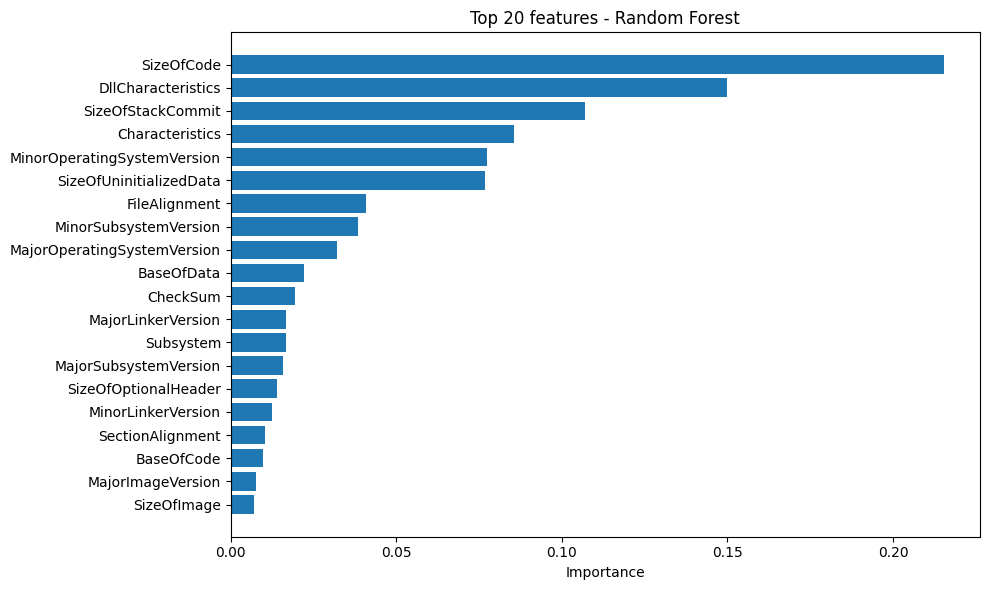

In [36]:
#============================
#  Importance des features
#============================
import numpy as np

importances = classif.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Top 20 features - Random Forest")
plt.barh(range(20), importances[indices[:20]][::-1], align='center')
plt.yticks(range(20), [MalwareDataset.columns[2+indices[i]] for i in range(19,-1,-1)])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [37]:
#====================
# Validation croisée
#====================

# Pour vérifier la robustesse du modèle et détecter un éventuel surapprentissage, nous utilisons **cross_validate** avec accuracy et F1-score

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, learning_curve, GridSearchCV

cv_results = cross_validate(classif, X_train_scaled, y_train, cv=5, scoring=['accuracy','f1'])
print("Validation croisée (accuracy et F1-score):")
print(cv_results)


Validation croisée (accuracy et F1-score):
{'fit_time': array([13.45817208, 17.82558703, 17.2365458 , 21.03542829, 17.07329512]), 'score_time': array([0.27163529, 0.3624382 , 0.46815848, 0.16729546, 0.32165313]), 'test_accuracy': array([0.99456719, 0.99474828, 0.99411418, 0.99465749, 0.9952008 ]), 'test_f1': array([0.99093245, 0.99122542, 0.99018868, 0.99107818, 0.99199396])}


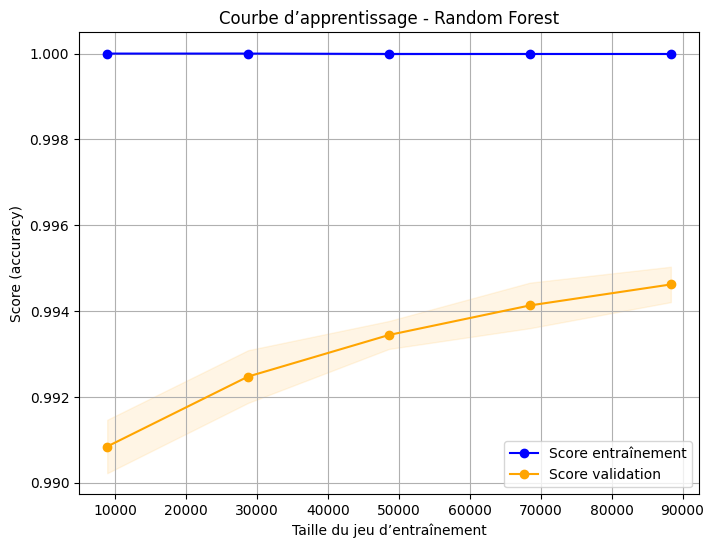

In [39]:
#====================
# 7️⃣ Learning curve
#====================

train_sizes, train_scores, test_scores = learning_curve(
    classif,
    X_train_scaled,
    y_train,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Score entraînement')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, 'o-', color='orange', label='Score validation')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='orange')
plt.title("Courbe d’apprentissage - Random Forest")
plt.xlabel("Taille du jeu d’entraînement")
plt.ylabel("Score (accuracy)")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [41]:
#=================================
# 8️⃣ GridSearch pour optimisation
#=================================

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid, cv=3, scoring='accuracy')
grid_rf.fit(X_train_scaled, y_train)
print("Meilleurs hyperparamètres GridSearch:", grid_rf.best_params_)

Meilleurs hyperparamètres GridSearch: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [42]:
#===========================
# 9️⃣ Sauvegarde du modèle
#===========================
import joblib

joblib.dump(classif, "random_forest_pe_headers.pkl")
print("Modèle Random Forest sauvegardé dans random_forest_pe_headers.pkl")


Modèle Random Forest sauvegardé dans random_forest_pe_headers.pkl


In [44]:
#petit check des fichiers presents sur le disque colab
import os
os.listdir()

['.config', 'random_forest_pe_headers.pkl', 'sample_data']

In [45]:
#telecharger le fichier si on veut
#from google.colab import files
#files.download("random_forest_pe_headers.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



---



## **Gradient Boosting**

Le Gradient Boosting est une méthode d'apprentissage supervisé très puissante, utilisée pour la classification et la régression.  

### Comment ça fonctionne :
1. Il construit une **série d'arbres de décision faibles (weak learners)**, chacun corrigeant les erreurs du précédent.  
2. Chaque nouvel arbre est entraîné pour **minimiser les erreurs résiduelles** des arbres précédents.  
3. Les prédictions finales sont obtenues en **combinant tous les arbres**, généralement par une somme pondérée.

### Pourquoi l’utiliser pour la détection de malwares :
- Très efficace pour capturer des **patterns complexes dans les données**.  
- Peut améliorer la précision par rapport à un **Random Forest** simple.  
- Permet de **réduire les faux positifs et faux négatifs** si bien paramétré.


In [ ]:
classif_gradient = sklearn.ensemble.GradientBoostingClassifier(n_estimators=50)
classif_gradient.fit(X_train, y_train)
score_gradient = classif_gradient.score(X_test, y_test)
print("The accuracy of the algorithm is: %s" %(score_gradient*100))

The accuracy of the algorithm is: 98.86635277073525




---



### **AdaBoost Classifier**

**AdaBoost** (Adaptive Boosting) est une méthode d'**apprentissage supervisé** utilisée pour la classification (et parfois la régression).  

### Principe de fonctionnement :
1. AdaBoost construit une **série de classifieurs faibles** (souvent des petits arbres de décision).  
2. Chaque nouvel arbre se concentre **sur les erreurs des classifieurs précédents** :  
   - Les exemples mal classés reçoivent un **poids plus élevé** pour être mieux appris par le classifieur suivant.  
3. Les prédictions finales sont obtenues en **combinant tous les classifieurs** avec un système de **votes pondérés**.

### Pourquoi l’utiliser pour la détection de malwares :
- Il est capable de **corriger progressivement les erreurs** sur les fichiers difficiles à classer.  
- Peut améliorer la **précision globale** et réduire les **faux positifs et faux négatifs**.  
- Plus simple et souvent plus rapide à entraîner que le Gradient Boosting, tout en restant performant.


In [ ]:
classif_adboost = sklearn.ensemble.AdaBoostClassifier(n_estimators=100)
classif_adboost.fit(X_train, y_train)
score_adboost = classif_adboost.score(X_test, y_test)
print("The accuracy of the algorithm is: %s" %(score_adboost*100))

The accuracy of the algorithm is: 98.61282144150671


### **XGBoost**

In [ ]:
import xgboost as xgb

classif_xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, use_label_encoder=False, eval_metric='logloss')
classif_xgb.fit(X_train, y_train)
score_xgb = classif_xgb.score(X_test, y_test)
print("The accuracy of the XGBoost algorithm is: %s" %(score_xgb*100))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:29:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


The accuracy of the XGBoost algorithm is: 99.28649040202825
